# Telecom Churn Case Study

#### Group Members:
-Sahil Bajaj<br>
-Rajkumar Lakkimsetty

###### Business Problem Overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.
 
 

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

 

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

###### Definitions of Churn
There are various ways to define churn, such as: 1. Revenue-based churn   2.Usage-based churn

For this project, you will use the **usage-based** definition to define churn.

**Usage-based churn:** Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.
A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator. 

###### business objective:
The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

In [1]:
# Ignoring warning messages
import warnings
warnings.filterwarnings('ignore')

# Import the required library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from imblearn.over_sampling import SMOTE

pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 300)

## Data Understanding

In [2]:
# Reading the input data
tel_churn = pd.read_csv('telecom_churn_data.csv')

In [3]:
tel_churn.head(10)

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,

In [4]:
tel_churn.shape

(99999, 226)

In [5]:
tel_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [6]:
tel_churn.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621

In [7]:
# List of columns
pd.DataFrame(tel_churn.columns)

,0
0,mobile_number
1,circle_id
2,loc_og_t2o_mou
3,std_og_t2o_mou
4,loc_ic_t2o_mou
5,last_date_of_month_6
6,last_date_of_month_7
7,last_date_of_month_8
8,last_date_of_month_9
9,arpu_6


## Data Cleaning

In [8]:
# Checking percentage % of null values
round(100*(tel_churn.isnull().sum()/tel_churn.shape[0]))

mobile_number                0.0
circle_id                    0.0
loc_og_t2o_mou               1.0
std_og_t2o_mou               1.0
loc_ic_t2o_mou               1.0
last_date_of_month_6         0.0
last_date_of_month_7         1.0
last_date_of_month_8         1.0
last_date_of_month_9         2.0
arpu_6                       0.0
arpu_7                       0.0
arpu_8                       0.0
arpu_9                       0.0
onnet_mou_6                  4.0
onnet_mou_7                  4.0
onnet_mou_8                  5.0
onnet_mou_9                  8.0
offnet_mou_6                 4.0
offnet_mou_7                 4.0
offnet_mou_8                 5.0
offnet_mou_9                 8.0
roam_ic_mou_6                4.0
roam_ic_mou_7                4.0
roam_ic_mou_8                5.0
roam_ic_mou_9                8.0
roam_og_mou_6                4.0
roam_og_mou_7                4.0
roam_og_mou_8                5.0
roam_og_mou_9                8.0
loc_og_t2t_mou_6             4.0
loc_og_t2t

**Creating function for handling missing values**

In [9]:
def getMissVal(missingCutoff):
    # Function to retun the columns with more than missingCutoff% missing values.
    # argument: missingCutoff, % values threshold for missing values
    missing = round(100*(tel_churn.isnull().sum()/tel_churn.shape[0]))
    print("There are {} features having more than {}% missing values/entries".format(len(missing.loc[missing > missingCutoff]),missingCutoff))
    return missing.loc[missing > missingCutoff]

In [10]:
def imputeNan(data,imputeColList=False,missingColList=False):
    # Function impute the nan with 0
    # argument: colList, list of columns for which nan is to be replaced with 0
    if imputeColList:
        for col in [y + s for s in ['_6','_7','_8','_9'] for y in imputeColList]:
            data[col].fillna(0, inplace=True)
    else:    
        for col in missingColList:
            data[col].fillna(0, inplace=True)

**Columns with more than 50% of missing values**

In [11]:
getMissVal(50)

There are 40 features having more than 50% missing values/entries


date_of_last_rech_data_6    75.0
date_of_last_rech_data_7    74.0
date_of_last_rech_data_8    74.0
date_of_last_rech_data_9    74.0
total_rech_data_6           75.0
total_rech_data_7           74.0
total_rech_data_8           74.0
total_rech_data_9           74.0
max_rech_data_6             75.0
max_rech_data_7             74.0
max_rech_data_8             74.0
max_rech_data_9             74.0
count_rech_2g_6             75.0
count_rech_2g_7             74.0
count_rech_2g_8             74.0
count_rech_2g_9             74.0
count_rech_3g_6             75.0
count_rech_3g_7             74.0
count_rech_3g_8             74.0
count_rech_3g_9             74.0
av_rech_amt_data_6          75.0
av_rech_amt_data_7          74.0
av_rech_amt_data_8          74.0
av_rech_amt_data_9          74.0
arpu_3g_6                   75.0
arpu_3g_7                   74.0
arpu_3g_8                   74.0
arpu_3g_9                   74.0
arpu_2g_6                   75.0
arpu_2g_7                   74.0
arpu_2g_8 

In [12]:
#Since av_rech_amt_data_* features are important for getting the high-value customers
#lets impute the missing av_rech_amt_data_* with 0
imputeCol = ['av_rech_amt_data', 'arpu_2g', 'arpu_3g', 'count_rech_2g', 'count_rech_3g',
             'max_rech_data', 'total_rech_data','fb_user','night_pck_user']
imputeNan(tel_churn,imputeCol)

In [13]:
getMissVal(50)

There are 4 features having more than 50% missing values/entries


date_of_last_rech_data_6    75.0
date_of_last_rech_data_7    74.0
date_of_last_rech_data_8    74.0
date_of_last_rech_data_9    74.0
dtype: float64

In [14]:
# dropping the columns having more than 50% missing values
missingcolumn = list(getMissVal(50).index)
tel_churn.drop(missingcolumn,axis=1,inplace=True)
tel_churn.shape

There are 4 features having more than 50% missing values/entries


(99999, 222)

**Columns with more than 5% of missing values**

In [15]:
getMissVal(5)

There are 29 features having more than 5% missing values/entries


onnet_mou_9         8.0
offnet_mou_9        8.0
roam_ic_mou_9       8.0
roam_og_mou_9       8.0
loc_og_t2t_mou_9    8.0
loc_og_t2m_mou_9    8.0
loc_og_t2f_mou_9    8.0
loc_og_t2c_mou_9    8.0
loc_og_mou_9        8.0
std_og_t2t_mou_9    8.0
std_og_t2m_mou_9    8.0
std_og_t2f_mou_9    8.0
std_og_t2c_mou_9    8.0
std_og_mou_9        8.0
isd_og_mou_9        8.0
spl_og_mou_9        8.0
og_others_9         8.0
loc_ic_t2t_mou_9    8.0
loc_ic_t2m_mou_9    8.0
loc_ic_t2f_mou_9    8.0
loc_ic_mou_9        8.0
std_ic_t2t_mou_9    8.0
std_ic_t2m_mou_9    8.0
std_ic_t2f_mou_9    8.0
std_ic_t2o_mou_9    8.0
std_ic_mou_9        8.0
spl_ic_mou_9        8.0
isd_ic_mou_9        8.0
ic_others_9         8.0
dtype: float64

Checking if all the above features for the month of September(9) are missing together.

In [16]:
missingcolumn = list(getMissVal(5).index)
print ("There are %d customers/MSISDN's having missing values for %s together"%(len(tel_churn[tel_churn[missingcolumn].isnull().all(axis=1)]),missingcolumn))
tel_churn[tel_churn[missingcolumn].isnull().all(axis=1)][missingcolumn].head()

There are 29 features having more than 5% missing values/entries
There are 7745 customers/MSISDN's having missing values for ['onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_9', 'std_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9'] together


,onnet_mou_9,offnet_mou_9,roam_ic_mou_9,roam_og_mou_9,loc_og_t2t_mou_9,loc_og_t2m_mou_9,loc_og_t2f_mou_9,loc_og_t2c_mou_9,loc_og_mou_9,std_og_t2t_mou_9,std_og_t2m_mou_9,std_og_t2f_mou_9,std_og_t2c_mou_9,std_og_mou_9,isd_og_mou_9,spl_og_mou_9,og_others_9,loc_ic_t2t_mou_9,loc_ic_t2m_mou_9,loc_ic_t2f_mou_9,loc_ic_mou_9,std_ic_t2t_mou_9,std_ic_t2m_mou_9,std_ic_t2f_mou_9,std_ic_t2o_mou_9,std_ic_mou_9,spl_ic_mou_9,isd_ic_mou_9,ic_others_9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# There are 7745 customers with empty values together for above features
# Lets impute these missing value with 0
imputeNan(tel_churn,missingColList=missingcolumn)

In [18]:
tel_churn=tel_churn[~tel_churn[missingcolumn].isnull().all(axis=1)]
tel_churn.shape

(99999, 222)

**Columns with more than 2% of missing values**

In [19]:
getMissVal(2)

There are 89 features having more than 2% missing values/entries


onnet_mou_6            4.0
onnet_mou_7            4.0
onnet_mou_8            5.0
offnet_mou_6           4.0
offnet_mou_7           4.0
offnet_mou_8           5.0
roam_ic_mou_6          4.0
roam_ic_mou_7          4.0
roam_ic_mou_8          5.0
roam_og_mou_6          4.0
roam_og_mou_7          4.0
roam_og_mou_8          5.0
loc_og_t2t_mou_6       4.0
loc_og_t2t_mou_7       4.0
loc_og_t2t_mou_8       5.0
loc_og_t2m_mou_6       4.0
loc_og_t2m_mou_7       4.0
loc_og_t2m_mou_8       5.0
loc_og_t2f_mou_6       4.0
loc_og_t2f_mou_7       4.0
loc_og_t2f_mou_8       5.0
loc_og_t2c_mou_6       4.0
loc_og_t2c_mou_7       4.0
loc_og_t2c_mou_8       5.0
loc_og_mou_6           4.0
loc_og_mou_7           4.0
loc_og_mou_8           5.0
std_og_t2t_mou_6       4.0
std_og_t2t_mou_7       4.0
std_og_t2t_mou_8       5.0
std_og_t2m_mou_6       4.0
std_og_t2m_mou_7       4.0
std_og_t2m_mou_8       5.0
std_og_t2f_mou_6       4.0
std_og_t2f_mou_7       4.0
std_og_t2f_mou_8       5.0
std_og_t2c_mou_6       4.0
s

In [20]:
missingcolumn = list(getMissVal(2).index)
print ("There are %d customers/MSISDN's having missing values for %s together"%(len(tel_churn[tel_churn[missingcolumn].isnull().all(axis=1)]),missingcolumn))
tel_churn[tel_churn[missingcolumn].isnull().all(axis=1)][missingcolumn].head()

There are 89 features having more than 2% missing values/entries
There are 381 customers/MSISDN's having missing values for ['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_othe

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,date_of_last_rech_8,date_of_last_rech_9
202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# There are 381 customers with empty values together for above features
tel_churn=tel_churn[~tel_churn[missingcolumn].isnull().all(axis=1)]
tel_churn.shape

(99618, 222)

In [22]:
# let's impute them with zero
missingcolumn.remove('date_of_last_rech_8')
missingcolumn.remove('date_of_last_rech_9')
imputeNan(tel_churn,missingColList=missingcolumn)

**Columns with more than 0% of missing values**

In [23]:
getMissVal(0)

There are 9 features having more than 0% missing values/entries


loc_og_t2o_mou          1.0
std_og_t2o_mou          1.0
loc_ic_t2o_mou          1.0
last_date_of_month_8    1.0
last_date_of_month_9    1.0
date_of_last_rech_6     1.0
date_of_last_rech_7     1.0
date_of_last_rech_8     3.0
date_of_last_rech_9     4.0
dtype: float64

In [24]:
# Checking the unique values in above columns
col = ['loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','last_date_of_month_7','last_date_of_month_8','last_date_of_month_9', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9']
for c in col: 
    print("Unique values in column %s are %s" % (c,tel_churn[c].unique()))

Unique values in column loc_og_t2o_mou are [ 0. nan]
Unique values in column std_og_t2o_mou are [ 0. nan]
Unique values in column loc_ic_t2o_mou are [ 0. nan]
Unique values in column last_date_of_month_7 are ['7/31/2014' nan]
Unique values in column last_date_of_month_8 are ['8/31/2014' nan]
Unique values in column last_date_of_month_9 are ['9/30/2014' nan]
Unique values in column date_of_last_rech_7 are ['7/16/2014' '7/31/2014' '7/24/2014' '7/28/2014' '7/17/2014' '7/25/2014'
 '7/23/2014' '7/5/2014' '7/10/2014' '7/22/2014' '7/30/2014' '7/3/2014'
 '7/7/2014' '7/29/2014' '7/27/2014' '7/19/2014' '7/14/2014' '7/20/2014'
 '7/4/2014' '7/12/2014' nan '7/26/2014' '7/11/2014' '7/6/2014' '7/21/2014'
 '7/13/2014' '7/15/2014' '7/18/2014' '7/9/2014' '7/2/2014' '7/8/2014'
 '7/1/2014']
Unique values in column date_of_last_rech_8 are ['8/8/2014' '8/28/2014' '8/14/2014' '8/31/2014' '8/9/2014' '8/24/2014'
 '8/26/2014' '8/30/2014' '8/29/2014' '8/27/2014' '8/21/2014' '8/10/2014'
 '8/25/2014' '8/19/2014' '

In [25]:
#Some of these features take only one value. Lets impute their missing values in these features with the mode
col = ['loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','last_date_of_month_7','last_date_of_month_8','last_date_of_month_9']
for c in col:
    print(tel_churn[c].value_counts())
    tel_churn[c].fillna(tel_churn[c].mode()[0], inplace=True)
print("All the above features take only one value. Lets impute the missing values in these features with the mode")


0.0    98981
Name: loc_og_t2o_mou, dtype: int64
0.0    98981
Name: std_og_t2o_mou, dtype: int64
0.0    98981
Name: loc_ic_t2o_mou, dtype: int64
7/31/2014    99300
Name: last_date_of_month_7, dtype: int64
8/31/2014    98867
Name: last_date_of_month_8, dtype: int64
9/30/2014    98321
Name: last_date_of_month_9, dtype: int64
All the above features take only one value. Lets impute the missing values in these features with the mode


In [26]:
# Checking again for columns more than 0% of missing values
getMissVal(0)

There are 4 features having more than 0% missing values/entries


date_of_last_rech_6    1.0
date_of_last_rech_7    1.0
date_of_last_rech_8    3.0
date_of_last_rech_9    4.0
dtype: float64

In [27]:
# All these features are missing together
missingcolumn = list(getMissVal(0).index)
print ("There are %d rows in total having missing values for these variables."%(len(tel_churn[tel_churn[missingcolumn].isnull().all(axis=1)])))

There are 4 features having more than 0% missing values/entries
There are 22 rows in total having missing values for these variables.


In [28]:
tel_churn[tel_churn['date_of_last_rech_6'].isnull()]['date_of_last_rech_6'] = '6/30/2014'
tel_churn[tel_churn['date_of_last_rech_7'].isnull()]['date_of_last_rech_7'] = '7/31/2014'
tel_churn[tel_churn['date_of_last_rech_8'].isnull()]['date_of_last_rech_8'] = '8/31/2014'
tel_churn[tel_churn['date_of_last_rech_9'].isnull()]['date_of_last_rech_9'] = '9/30/2014'

In [29]:
# Checking columns with zero values
zero_columns=tel_churn.columns[(tel_churn == 0).all()]
print ("There are {} features which has only 0 as values. These features are \n{}".format(len(zero_columns),zero_columns))

There are 11 features which has only 0 as values. These features are 
Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7',
       'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9'],
      dtype='object')


In [30]:
# Let's remove these columns as well. All take a single value '0'. 
tel_churn.drop(zero_columns,axis=1,inplace=True)

In [31]:
# Percentage of data left after removing the missing values.
print("Percentage of data remaining after treating missing values: {}%".format(round(tel_churn.shape[0]/99999 *100,2)))
print ("Number of customers: {}".format(tel_churn.shape[0]))
print ("Number of features: {}".format(tel_churn.shape[1]))

Percentage of data remaining after treating missing values: 99.62%
Number of customers: 99618
Number of features: 211


**Fixing Data Types and Columns names**

In [32]:
# Checking the data types of every column
tel_churn.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99618 entries, 0 to 99998
Data columns (total 211 columns):
 #   Column                Dtype  
---  ------                -----  
 0   mobile_number         int64  
 1   circle_id             int64  
 2   last_date_of_month_6  object 
 3   last_date_of_month_7  object 
 4   last_date_of_month_8  object 
 5   last_date_of_month_9  object 
 6   arpu_6                float64
 7   arpu_7                float64
 8   arpu_8                float64
 9   arpu_9                float64
 10  onnet_mou_6           float64
 11  onnet_mou_7           float64
 12  onnet_mou_8           float64
 13  onnet_mou_9           float64
 14  offnet_mou_6          float64
 15  offnet_mou_7          float64
 16  offnet_mou_8          float64
 17  offnet_mou_9          float64
 18  roam_ic_mou_6         float64
 19  roam_ic_mou_7         float64
 20  roam_ic_mou_8         float64
 21  roam_ic_mou_9         float64
 22  roam_og_mou_6         float64
 23  roam_og_mo

In [33]:
tel_churn.reset_index(inplace=True,drop=True)
# list of all columns which store date
date_col = list(tel_churn.filter(regex='date').columns)
date_col

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9']

In [34]:
# Converting dtype of date columns to datetime
for col in date_col:
    tel_churn[col] = pd.to_datetime(tel_churn[col], format='%m/%d/%Y')

In [35]:
tel_churn.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99618 entries, 0 to 99617
Data columns (total 211 columns):
 #   Column                Dtype         
---  ------                -----         
 0   mobile_number         int64         
 1   circle_id             int64         
 2   last_date_of_month_6  datetime64[ns]
 3   last_date_of_month_7  datetime64[ns]
 4   last_date_of_month_8  datetime64[ns]
 5   last_date_of_month_9  datetime64[ns]
 6   arpu_6                float64       
 7   arpu_7                float64       
 8   arpu_8                float64       
 9   arpu_9                float64       
 10  onnet_mou_6           float64       
 11  onnet_mou_7           float64       
 12  onnet_mou_8           float64       
 13  onnet_mou_9           float64       
 14  offnet_mou_6          float64       
 15  offnet_mou_7          float64       
 16  offnet_mou_8          float64       
 17  offnet_mou_9          float64       
 18  roam_ic_mou_6         float64       
 19  roa

<br><br> There are some monthly features which are not in the standard naming (\_6,\_7,\_8,\_9)

In [36]:
# renaming columns,
#'jun_vbc_3g' : 'vbc_3g_6'
#'jul_vbc_3g' : 'vbc_3g_7'
#'aug_vbc_3g' : 'vbc_3g_8'
#'sep_vbc_3g' : 'vbc_3g_9'
tel_churn.rename(columns={'jun_vbc_3g' : 'vbc_3g_6', 'jul_vbc_3g' : 'vbc_3g_7', 'aug_vbc_3g' : 'vbc_3g_8',
                      'sep_vbc_3g' : 'vbc_3g_9'}, inplace=True)

**Creating new feature:** 'vol_data_mb_6', 'vol_data_mb_7', 'vol_data_mb_8', 'vol_data_mb_9'

These will store the total data volume (= vol_2g_mb_* + vol_3g_mb_*) used by user.

In [37]:
#Creating new feature: 'vol_data_mb_6', 'vol_data_mb_7', 'vol_data_mb_8', 'vol_data_mb_9',
for i in range(6,10):
    tel_churn['vol_data_mb_'+str(i)] = (tel_churn['vol_2g_mb_'+str(i)]+tel_churn['vol_3g_mb_'+str(i)]).astype(int)

**Filter high-value customers**

Defining high-value customers as follows:

Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [38]:
rechcol = tel_churn.filter(regex=('count')).columns
tel_churn[rechcol].head()

,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9
0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Creating new feature:** avg_rech_amt_6,avg_rech_amt_7,avg_rech_amt_8,avg_rech_amt_9

These will store the average recharge value for each customer for every month

In [39]:
# Creating new feature: avg_rech_amt_6,avg_rech_amt_7,avg_rech_amt_8,avg_rech_amt_9
for i in range(6,10):
    tel_churn['avg_rech_amt_'+str(i)] = round(tel_churn['total_rech_amt_'+str(i)]/tel_churn['total_rech_num_'+str(i)]+1,2)

In [40]:
imputeNan(tel_churn,missingColList=['avg_rech_amt_6','avg_rech_amt_7','avg_rech_amt_8','avg_rech_amt_9'])

**Creating new feature:** total_rech_num_data_6,total_rech_num_data_7,total_rech_num_data_8,total_rech_num_data_9

These will store the total number of data recharge (=count_rech_2g + count_rech_3g ) for each month.

In [41]:
#Creating new feature: total_rech_num_data_6,total_rech_num_data_7,total_rech_num_data_8,total_rech_num_data_9
for i in range(6,10):
    tel_churn['total_rech_num_data_'+str(i)] = (tel_churn['count_rech_2g_'+str(i)]+tel_churn['count_rech_3g_'+str(i)]).astype(int)

**Creating new feature:** total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_rech_amt_data_9

These will store the total amount of data recharge (=total_rech_num_data * av_rech_amt_data ) for each month.

In [42]:
#Creating new feature: total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_rech_amt_data_9
for i in range(6,10):
    tel_churn['total_rech_amt_data_'+str(i)] = tel_churn['total_rech_num_data_'+str(i)]*tel_churn['av_rech_amt_data_'+str(i)]

**Creating new feature:** total_month_rech_6,total_month_rech_7,total_month_rech_8,total_month_rech_9

These will store the total recharge amount (= total_rech_amt + total_rech_amt_data ) for each customer, for each month.

In [43]:
#Creating new feature: total_mon_rech_6,total_mon_rech_7,total_mon_rech_8,total_mon_rech_9
for i in range(6,10):
    tel_churn['total_month_rech_'+str(i)] = tel_churn['total_rech_amt_'+str(i)]+tel_churn['total_rech_amt_data_'+str(i)]
tel_churn.filter(regex=('total_month_rech')).head()

,total_month_rech_6,total_month_rech_7,total_month_rech_8,total_month_rech_9
0,614.0,504.0,504.0,0.0
1,74.0,538.0,383.0,121.0
2,168.0,315.0,116.0,404.0
3,230.0,310.0,601.0,410.0
4,252.0,350.0,287.0,200.0


In [44]:
# calculating the avegare of first two months (good phase) total monthly recharge amount
avg_goodPhase =(tel_churn.total_month_rech_6 + tel_churn.total_month_rech_7)/2
# finding the cutoff which is the 70th percentile of the good phase average recharge amounts
hv_cutoff= np.percentile(avg_goodPhase,70)
# Filtering the users whose good phase avg. recharge amount >= to the cutoff of 70th percentile.
hv_users = tel_churn[avg_goodPhase >=  hv_cutoff]
hv_users.reset_index(inplace=True,drop=True)

print("Number of High-Value Customers in the Dataset: %d\n"% len(hv_users))
print("Percentage High-value users in data : {}%".format(round(len(hv_users)/tel_churn.shape[0]*100),2))

Number of High-Value Customers in the Dataset: 29906

Percentage High-value users in data : 30%


**Tagging Churners**

Now tag the churned customers (churn=1, else 0) based on the fourth month as follows:

Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes we need to use to tag churners are:
- total_ic_mou_9
- total_og_mou_9
- vol_2g_mb_9
- vol_3g_mb_9

In [45]:
def getChurnStat(data,churnPhaseMonth=9):
    # Function to tag customers as churners (churn=1, else 0) based on 'vol_2g_mb_','vol_3g_mb_','total_ic_mou_','total_og_mou_'
    #argument: churnPhaseMonth, indicating the month number to be used to define churn (default= 9)
    churn_features= ['vol_2g_mb_','vol_3g_mb_','total_ic_mou_','total_og_mou_']
    flag = ~data[[s + str(churnPhaseMonth) for s in churn_features ]].any(axis=1)
    flag = flag.map({True:1, False:0})
    return flag

In [46]:
hv_users['churn'] = getChurnStat(hv_users,9)
print("There are {} users tagged as churners out of {} High-Value Customers.".format(len(hv_users[hv_users.churn == 1]),hv_users.shape[0]))
print("High-value Churn Percentage : {}%".format(round(len(hv_users[hv_users.churn == 1])/hv_users.shape[0] *100,2)))


There are 2418 users tagged as churners out of 29906 High-Value Customers.
High-value Churn Percentage : 8.09%


There are just **8.09% churn** cases.
This indicated an **highly imbalanced** data set where the churn cases are the minority(8.14%) as opposed to the non-churners who are the majority(91.91)

## Exploratory Data Analysis

**Creating function for plotting graphs**

In [47]:
# Function to plot the histogram with labels
def plot_hist(dataset,col,binsize):
    fig, ax = plt.subplots(figsize=(20,4))
    counts, bins, patches = ax.hist(dataset[col],bins=range(0,dataset[col].max(),round(binsize)), facecolor='lightgreen', edgecolor='gray')
    
    # Set the ticks to be at the edges of the bins.
    ax.set_xticks(bins)
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    for count, x in zip(counts, bin_centers):
        # Label the percentages
        percent = '%0.0f%%' % (100 * float(count) / counts.sum())
        ax.annotate(percent, xy=(x,0.2), xycoords=('data', 'axes fraction'),
        xytext=(0, -32), textcoords='offset points', va='top', ha='center')
    
    ax.set_xlabel(col.upper())
    ax.set_ylabel('Count')
    # Give ourselves some more room at the bottom of the plot
    #plt.subplots_adjust(bottom=0.15)
    plt.show()
    

In [48]:
def plot_avgMonthlyCalls(pltType,data,calltype,colList):
    # style
    plt.style.use('seaborn-darkgrid')
    # create a color palette
    palette = plt.get_cmap('Set1')
    
    if pltType == 'multi':
        #Create dataframe after grouping on AON with colList features
        total_call_mou = pd.DataFrame(data.groupby('aon_bin',as_index=False)[colList].mean())
        total_call_mou['aon_bin']=pd.to_numeric(total_call_mou['aon_bin'])
        total_call_mou
        # multiple line plot
        num=0
        fig, ax = plt.subplots(figsize=(15,8))
        for column in total_call_mou.drop('aon_bin', axis=1):
            num+=1
            ax.plot(total_call_mou['aon_bin'] , total_call_mou[column], marker='', color=palette(num), linewidth=2, alpha=0.9, label=column)
         
        ## Add legend
        plt.legend(loc=2, ncol=2)
        ax.set_xticks(total_call_mou['aon_bin'])
        
        # Add titles
        plt.title("Avg.Monthly "+calltype+" MOU  V/S AON", loc='left', fontsize=12, fontweight=0, color='orange')
        plt.xlabel("Aon (years)")
        plt.ylabel("Avg. Monthly "+calltype+" MOU")
    elif pltType == 'single':
        fig, ax = plt.subplots(figsize=(8,4))
        ax.plot(data[colList].mean())
        ax.set_xticklabels(['Jun','Jul','Aug','Sep'])
        
        # Add titles
        plt.title("Avg. "+calltype+" MOU  V/S Month", loc='left', fontsize=12, fontweight=0, color='orange')
        plt.xlabel("Month")
        plt.ylabel("Avg. "+calltype+" MOU")
        
    plt.show()

In [49]:
def plot_byChurnMou(colList,calltype):
    fig, ax = plt.subplots(figsize=(7,4))
    df=hv_users.groupby(['churn'])[colList].mean().T
    plt.plot(df)
    ax.set_xticklabels(['Jun','Jul','Aug','Sep'])
    ## Add legend
    plt.legend(['Non-Churn', 'Churn'])
    # Add titles
    plt.title("Avg. "+calltype+" MOU  V/S Month", loc='left', fontsize=12, fontweight=0, color='orange')
    plt.xlabel("Month")
    plt.ylabel("Avg. "+calltype+" MOU")

In [50]:
def plot_byChurn(data,col):
    # per month churn vs Non-Churn
    fig, ax = plt.subplots(figsize=(7,4))
    colList=list(data.filter(regex=(col)).columns)
    colList = colList[:3]
    plt.plot(hv_users.groupby('churn')[colList].mean().T)
    ax.set_xticklabels(['Jun','Jul','Aug','Sep'])
    ## Add legend
    plt.legend(['Non-Churn', 'Churn'])
    # Add titles
    plt.title( str(col) +" V/S Month", loc='left', fontsize=12, fontweight=0, color='orange')
    plt.xlabel("Month")
    plt.ylabel(col)
    plt.show()
    # Numeric stats for per month churn vs Non-Churn
    return hv_users.groupby('churn')[colList].mean()

In [51]:
# Filtering the common monthly columns for each month
comcol = hv_users.filter(regex ='_6').columns
monthlycol = [item.strip('_6') for item in comcol]
monthlycol

['last_date_of_month',
 'arpu',
 'onnet_mou',
 'offnet_mou',
 'roam_ic_mou',
 'roam_og_mou',
 'loc_og_t2t_mou',
 'loc_og_t2m_mou',
 'loc_og_t2f_mou',
 'loc_og_t2c_mou',
 'loc_og_mou',
 'std_og_t2t_mou',
 'std_og_t2m_mou',
 'std_og_t2f_mou',
 'std_og_mou',
 'isd_og_mou',
 'spl_og_mou',
 'og_others',
 'total_og_mou',
 'loc_ic_t2t_mou',
 'loc_ic_t2m_mou',
 'loc_ic_t2f_mou',
 'loc_ic_mou',
 'std_ic_t2t_mou',
 'std_ic_t2m_mou',
 'std_ic_t2f_mou',
 'std_ic_mou',
 'total_ic_mou',
 'spl_ic_mou',
 'isd_ic_mou',
 'ic_others',
 'total_rech_num',
 'total_rech_amt',
 'max_rech_amt',
 'date_of_last_rech',
 'last_day_rch_amt',
 'total_rech_data',
 'max_rech_data',
 'count_rech_2g',
 'count_rech_3g',
 'av_rech_amt_data',
 'vol_2g_mb',
 'vol_3g_mb',
 'arpu_3g',
 'arpu_2g',
 'night_pck_user',
 'monthly_2g',
 'sachet_2g',
 'monthly_3g',
 'sachet_3g',
 'fb_user',
 'vbc_3g',
 'vol_data_mb',
 'avg_rech_amt',
 'total_rech_num_data',
 'total_rech_amt_data',
 'total_month_rech']

In [52]:
# getting the number of monthly columns and profile columns
print ("Total number of columns in data :", hv_users.shape[1] )
print ("Number of columns for each month : ",len(monthlycol))
print ("Total monthly columns among the orignal columns (%d*4): %d"%(len(monthlycol), len(monthlycol) * 4))
print ("Columns other than monthly columns :", hv_users.shape[1] - (len(monthlycol) * 4))

Total number of columns in data : 232
Number of columns for each month :  57
Total monthly columns among the orignal columns (57*4): 228
Columns other than monthly columns : 4


In [53]:
# Lets remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).
col_9List = hv_users.filter(regex=('_9')).columns
hv_users.drop(col_9List,axis=1,inplace=True)

In [54]:
# list of all the monthly columns 6,7,8,9
allmonthlycol = [x + s for s in ['_6','_7','_8'] for x in monthlycol]
allmonthlycol

['last_date_of_month_6',
 'arpu_6',
 'onnet_mou_6',
 'offnet_mou_6',
 'roam_ic_mou_6',
 'roam_og_mou_6',
 'loc_og_t2t_mou_6',
 'loc_og_t2m_mou_6',
 'loc_og_t2f_mou_6',
 'loc_og_t2c_mou_6',
 'loc_og_mou_6',
 'std_og_t2t_mou_6',
 'std_og_t2m_mou_6',
 'std_og_t2f_mou_6',
 'std_og_mou_6',
 'isd_og_mou_6',
 'spl_og_mou_6',
 'og_others_6',
 'total_og_mou_6',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2f_mou_6',
 'loc_ic_mou_6',
 'std_ic_t2t_mou_6',
 'std_ic_t2m_mou_6',
 'std_ic_t2f_mou_6',
 'std_ic_mou_6',
 'total_ic_mou_6',
 'spl_ic_mou_6',
 'isd_ic_mou_6',
 'ic_others_6',
 'total_rech_num_6',
 'total_rech_amt_6',
 'max_rech_amt_6',
 'date_of_last_rech_6',
 'last_day_rch_amt_6',
 'total_rech_data_6',
 'max_rech_data_6',
 'count_rech_2g_6',
 'count_rech_3g_6',
 'av_rech_amt_data_6',
 'vol_2g_mb_6',
 'vol_3g_mb_6',
 'arpu_3g_6',
 'arpu_2g_6',
 'night_pck_user_6',
 'monthly_2g_6',
 'sachet_2g_6',
 'monthly_3g_6',
 'sachet_3g_6',
 'fb_user_6',
 'vbc_3g_6',
 'vol_data_mb_6',
 'avg_rech_

In [55]:
# list of column which are not monthly columns
nonmonthlycol = [col for col in hv_users.columns if col not in allmonthlycol]
nonmonthlycol

['mobile_number', 'circle_id', 'aon', 'churn']

#### Feature: circle_id

In [56]:
# Getting the distinct circle_id's in the data
hv_users.circle_id.value_counts()

109    29906
Name: circle_id, dtype: int64

Looks like the data at hand is only for a single **circle_id 109**.
We can remove this feature going forward as it is not contributing to analysis and model building.

In [57]:
hv_users.drop('circle_id',axis=1,inplace=True)

#### Feature: aon

count    29906.000000
mean      1209.062396
std        957.342718
min        180.000000
25%        460.000000
50%        846.000000
75%       1755.000000
max       4321.000000
Name: aon, dtype: float64


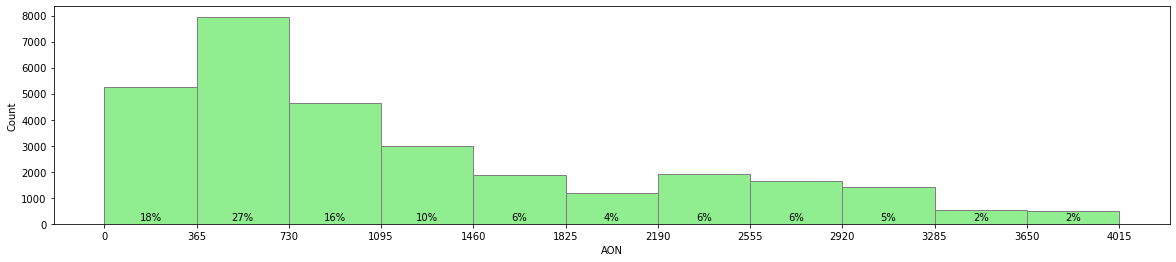

In [58]:
# Customers distribution of the age on network
print(hv_users.aon.describe())
plot_hist(hv_users,'aon',365)

- **Minimun Age** on network is 180 days.
- **Average age** on network for customers is 1200 days (3.2 years).
- 27% of the **HV users are in their 2nd year** with the network.
- Almost 71% users have Age on network **less than 4 years.**
- 15% users are with the network from **over 7 years.**

In [59]:
#Create Derived categorical variable
hv_users['aon_bin'] = pd.cut(tel_churn['aon'], range(0,tel_churn['aon'].max(),365), labels=range(0,int(round(tel_churn['aon'].max()/365))-1))

#### Incoming VS month VS AON

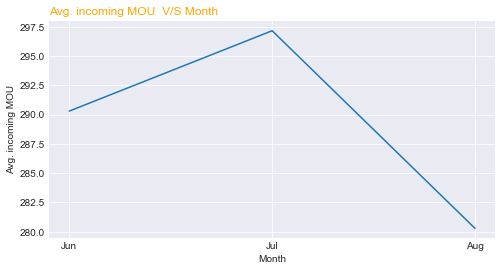

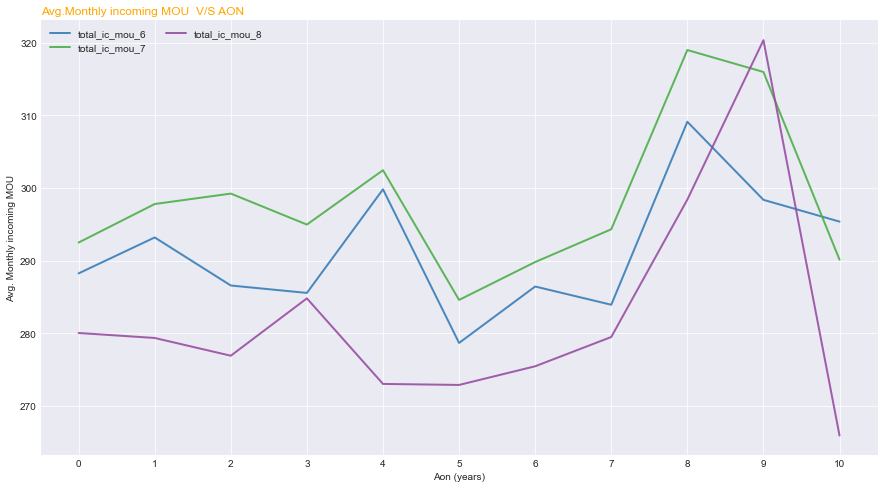

In [60]:
# Plotting Avg. total monthly incoming MOU vs AON
ic_col = hv_users.filter(regex ='total_ic_mou').columns
plot_avgMonthlyCalls('single',hv_users,calltype='incoming',colList=ic_col)
plot_avgMonthlyCalls('multi',hv_users,calltype='incoming',colList=ic_col)

It is evident from the plot that,
- The more a customer stays on with the operator(AON), more are the total monthly incoming MOU.
- Total Incoming MOU avg. for Jul(_7) are more than the previous Jun(_6) for customers in all AON bands.
- Total Incoming MOU avg. for Aug(_8) cease to increace, infact it shows a decline compared to Jul(_7).
- Total Incoming MOU avg. for Sep(_9) is well below the first months(jun _6) avg.
- Althought the Total incoming mou avg inceases from jun to july, it drop little from aug and reduces lower than that for jun.

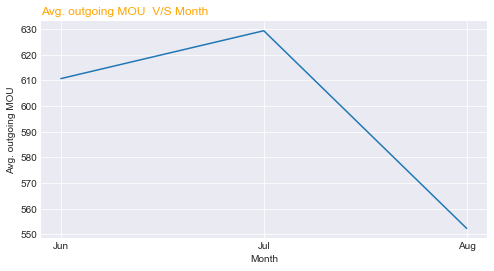

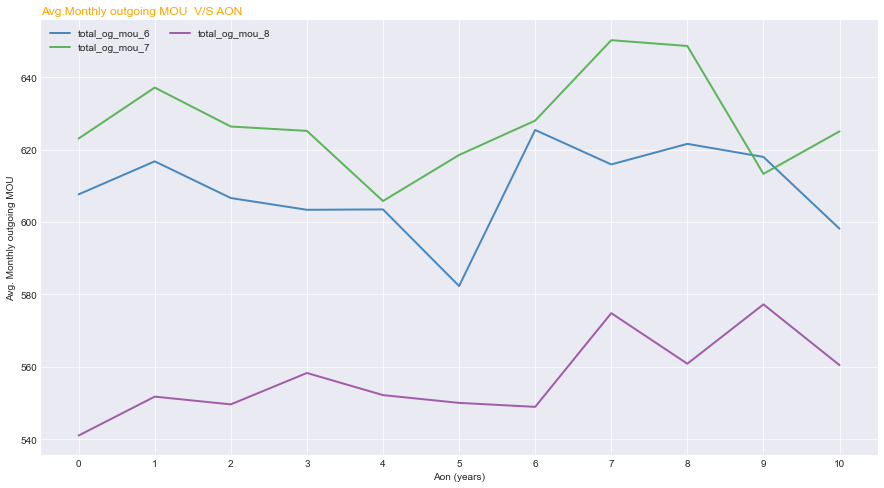

In [61]:
# Plotting Avg. total monthly outgoing MOU vs AON
og_col = hv_users.filter(regex ='total_og_mou').columns
plot_avgMonthlyCalls('single',hv_users,calltype='outgoing',colList=og_col)
plot_avgMonthlyCalls('multi',hv_users,calltype='outgoing',colList=og_col)

What is the above plot saying ?
- Overall, the Avg. total outgoing usage reduces with the increasing age on network.
- Total Outgoing MOU avg. for Jul(_7) are more than the previous Jun(_6) for customers in all AON bands, except in the AON band between 7 - 8 years where it is almost simillar.
- Total outgoing MOU avg. for Aug(_8) cease to increace, infact it shows a significant decline compared to Jul(_7).
- Total outgoing MOU avg. for Sep(_9) is the lowest of all 4 months.
- The Avg. outgoing usage reduces drastically for customers in the AON band between 7 - 8  years.

#### Incoming/Outgoing MOU VS Churn 

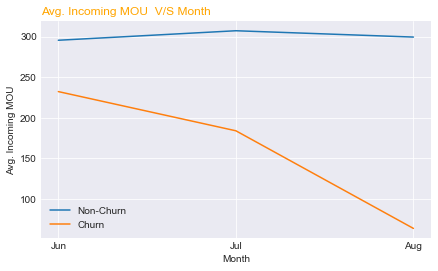

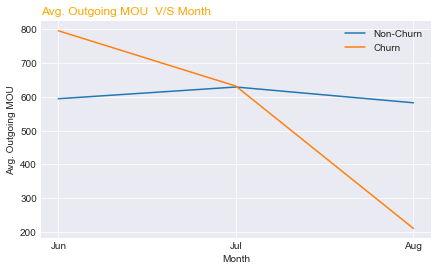

In [62]:
ic_col = ['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8']
og_col = ['total_og_mou_6','total_og_mou_7','total_og_mou_8']
plot_byChurnMou(ic_col,'Incoming')
plot_byChurnMou(og_col,'Outgoing')

It can be observed,
- Churners Avg. Incoming/Outgoing MOU's **drops drastically after the 2nd month,Jul.**
- While the non-churners Avg. MOU's remains consistant and stable with each month.
- Therefore, users MOU is a key feature to predict churn.

In [63]:
# Avg.Incoming MOU per month churn vs Non-Churn
hv_users.groupby(['churn'])['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8'].mean()

,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8
churn,,,
0,295.401726,307.108317,299.319664
1,232.221162,183.978888,63.813168


In [64]:
# Avg. Outgoing MOU per month churn vs Non-Churn
hv_users.groupby(['churn'])['total_og_mou_6','total_og_mou_7','total_og_mou_8'].mean()

,total_og_mou_6,total_og_mou_7,total_og_mou_8
churn,,,
0,594.414582,629.096568,582.380539
1,795.591038,631.859433,210.659326


**Create new feature:** og_to_ic_mou_6, og_to_ic_mou_7, og_to_ic_mou_8
These features will hold the **ratio** (=total_og_mou_* / total_ic_mou_*) for each month. These features will combine both incoming and outgoing informations and should be a **better predictor of churn.**

In [65]:
#Creating new feature: og_to_ic_mou_6, og_to_ic_mou_7, og_to_ic_mou_8
# adding 1 to denominator to avoid dividing by 0 and getting nan values.
for i in range(6,9):
    hv_users['og_to_ic_mou_'+str(i)] = (hv_users['total_og_mou_'+str(i)])/(hv_users['total_ic_mou_'+str(i)]+1)

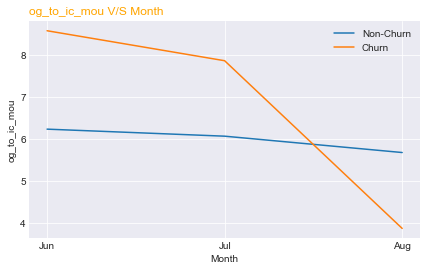

,og_to_ic_mou_6,og_to_ic_mou_7,og_to_ic_mou_8
churn,,,
0,6.235602,6.067952,5.678424
1,8.580257,7.865938,3.870145


In [66]:
plot_byChurn(hv_users,'og_to_ic_mou')

- Outgoing to incoming mou remains drops significantly for churners from month Jul(6) to Aug(7).
- While it remains almost consistent for the non-churners.

**Create new feature:** loc_og_to_ic_mou_6, loc_og_to_ic_mou_7, loc_og_to_ic_mou_8
These features will hold the **ratio** (=loc_og_mou_* / loc_ic_mou_*) for each month. These features will combine the local calls, both incoming and outgoing informations and should be a **better predictor of churn.**

In [67]:
#Create new feature: loc_og_to_ic_mou_6, loc_og_to_ic_mou_7, loc_og_to_ic_mou_8
# adding 1 to denominator to avoid dividing by 0 and getting nan values.
for i in range(6,9):
    hv_users['loc_og_to_ic_mou_'+str(i)] = (hv_users['loc_og_mou_'+str(i)])/(hv_users['loc_ic_mou_'+str(i)]+1)

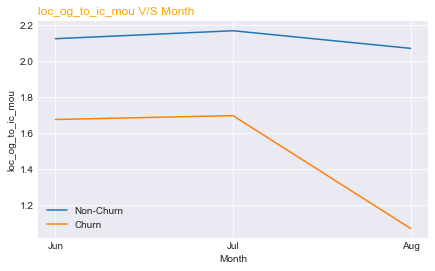

,loc_og_to_ic_mou_6,loc_og_to_ic_mou_7,loc_og_to_ic_mou_8
churn,,,
0,2.124471,2.168763,2.070806
1,1.675413,1.696809,1.069765


In [68]:
plot_byChurn(hv_users,'loc_og_to_ic_mou')

It can be observed that,
- The local outgoing to incoming call mou ratio is genrally low for churners right from the begining of the good phase.
- local mou pattern for the non-churners remains almost constant through out the 3 months.
- The churners genrally show a low loc mou ratio but it drops dramatically after the 2nd month.
- This might suggest that people who are not making/reciving much local calls during their tenure are more likely to churn.

#### Total data volume VS Churn 

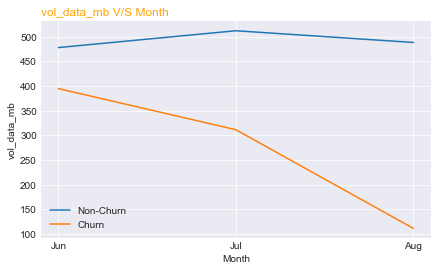

,vol_data_mb_6,vol_data_mb_7,vol_data_mb_8
churn,,,
0,478.037762,512.164072,488.389661
1,394.949545,311.507444,111.469396


In [69]:
plot_byChurn(hv_users,'vol_data_mb')

- The volume of data mb used drops significantly for churners from month Jul(6) to Aug(7).
- While it remains almost consistent for the non-churners.

#### Total monthly rech VS Churn

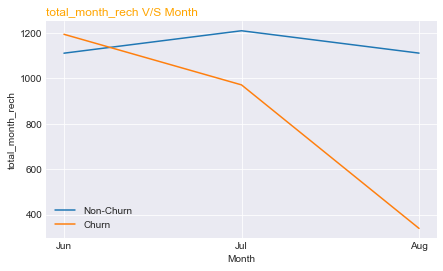

,total_month_rech_6,total_month_rech_7,total_month_rech_8
churn,,,
0,1111.439977,1210.362853,1111.756912
1,1194.747593,971.802758,339.278974


In [70]:
plot_byChurn(hv_users,'total_month_rech')

- total monthly rech amount also drops significantly for churners from month Jul(6) to Aug(7).
- While it remains almost consistent for the non-churners.

#### max_rech_amt VS Churn

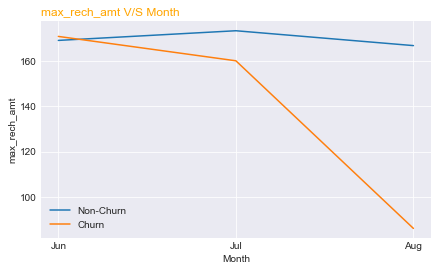

,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8
churn,,,
0,169.160943,173.437282,166.865250
1,170.930108,160.152192,86.026468


In [71]:
plot_byChurn(hv_users,'max_rech_amt')

- maximum recharge amount also drops significantly for churners from month Jul(6) to Aug(7).
- While it remains almost consistent for the non-churners.

#### arpu VS Churn

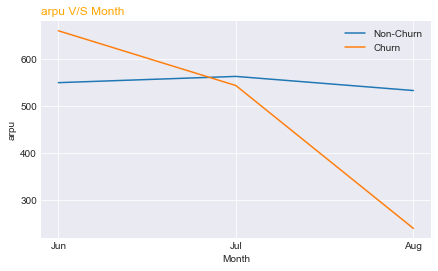

,arpu_6,arpu_7,arpu_8
churn,,,
0,549.843524,563.190828,533.052496
1,660.695411,543.722952,238.631887


In [72]:
plot_byChurn(hv_users,'arpu')

- Average revenue per user,arpu also drops significantly for churners from month Jul(6) to Aug(7).
- While it remains almost consistent for the non-churners.

**Create new feature:** Total_loc_mou_6, Total_loc_mou_7, Total_loc_mou_8<br>
These features will hold the **Total MOU** (=loc_og_mou+loc_ic_mou) for each month.<br>
Using this we will find if the loc MOU (both incoming and outgoing) drops or increaces as the months goes by.<br>
This informations should be a **better predictor of churn.**

In [73]:
#Create new feature: Total_loc_mou_6,Total_loc_mou_7,lTotal_loc_mou_8
for i in range(6,9):
    hv_users['Total_loc_mou_'+str(i)] = (hv_users['loc_og_mou_'+str(i)])+(hv_users['loc_ic_mou_'+str(i)])

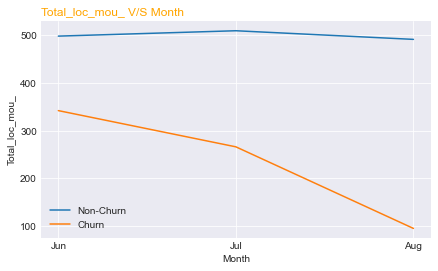

,Total_loc_mou_6,Total_loc_mou_7,Total_loc_mou_8
churn,,,
0,498.548969,509.835211,491.705600
1,342.113462,266.025666,94.701154


In [74]:
plot_byChurn(hv_users,'Total_loc_mou_')

It can be observed that,
- The Total local call mou is genrally low for churners right from the begining of the good phase.
- local mou pattern for the non-churners remains almost constant through out the 3 months.
- The churners genrally show a low total loc mou but it drops dramatically after the 2nd month.
- This might suggest that people who are not making/reciving much local calls during their tenure are more likely to churn.

**Create new feature:** Total_roam_mou_6,Total_roam_mou_7,Total_roam_mou_8<br>
These features will hold the **Total roaming MOU** (=roam_ic_mou+roam_og_mou) for each month.<br>
Using this we will find if the roam MOU (both incoming and outgoing) drops or increaces as the months goes by.<br>
This informations should be a **better predictor of churn.**

In [75]:
#Create new feature: Total_roam_mou_6,Total_roam_mou_7,Total_roam_mou_8
for i in range(6,9):
    hv_users['Total_roam_mou_'+str(i)] = (hv_users['roam_ic_mou_'+str(i)])+(hv_users['roam_og_mou_'+str(i)])

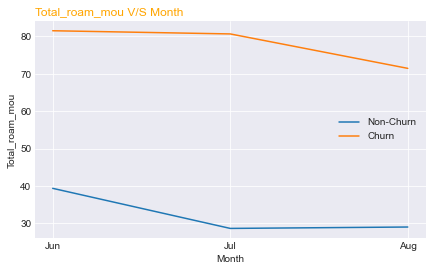

,Total_roam_mou_6,Total_roam_mou_7,Total_roam_mou_8
churn,,,
0,39.360033,28.643301,29.016734
1,81.504156,80.651973,71.443623


In [76]:
plot_byChurn(hv_users,'Total_roam_mou')

It can be observed that,
- Surprisingly, the roaming usage of churners is way higher than those of non-churners across all months
- People who are making/reciving more roaming calls during their tenure are more likely to churn.
- This might suggest that the operators roaming tariffs are higher than what are offered by its competitor, thus forming one of the reasons of churn.

####  last_day_rch_amt VS Churn

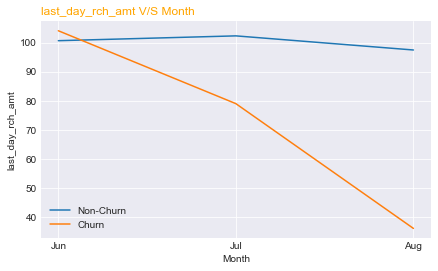

,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8
churn,,,
0,100.657232,102.318284,97.451724
1,104.085194,78.956989,35.955749


In [77]:
plot_byChurn(hv_users,'last_day_rch_amt')

- The avg. last recharge amount for churners is less than half the amount of that of the non-churners.
- Suggesting, as the recharge amount reduces for a customer its chances to churn increases.

## Data Modeling

In [78]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

In [79]:
def getModelMetrics(actual_churn=False,pred_churn=False):

    confusion = metrics.confusion_matrix(actual_churn, pred_churn)

    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives

    print("Roc_auc_score : {}".format(metrics.roc_auc_score(actual_churn,pred_churn)))
    # Let's see the sensitivity of our logistic regression model
    print('Sensitivity/Recall : {}'.format(TP / float(TP+FN)))
    # Let us calculate specificity
    print('Specificity: {}'.format(TN / float(TN+FP)))
    # Calculate false postive rate - predicting churn when customer does not have churned
    print('False Positive Rate: {}'.format(FP/ float(TN+FP)))
    # positive predictive value 
    print('Positive predictive value: {}'.format(TP / float(TP+FP)))
    # Negative predictive value
    print('Negative Predictive value: {}'.format(TN / float(TN+ FN)))
    # sklearn precision score value 
    print('sklearn precision score value: {}'.format(metrics.precision_score(actual_churn, pred_churn )))
    
    

In [80]:
def predictChurnWithProb(model,X,y,prob):
    # Funtion to predict the churn using the input probability cut-off
    # Input arguments: model instance, x and y to predict using model and cut-off probability
    
    # predict
    pred_probs = model.predict_proba(X)[:,1]
    
    y_df= pd.DataFrame({'churn':y, 'churn_Prob':pred_probs})
    # Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
    y_df['final_predicted'] = y_df.churn_Prob.map( lambda x: 1 if x > prob else 0)
    # Let's see the head
    getModelMetrics(y_df.churn,y_df.final_predicted)
    return y_df

In [81]:
def findOptimalCutoff(df):
    #Function to find the optimal cutoff for classifing as churn/non-churn
    # Let's create columns with different probability cutoffs 
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        df[i] = df.churn_Prob.map( lambda x: 1 if x > i else 0)
    #print(df.head())
    
    # Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
    from sklearn.metrics import confusion_matrix
    
    # TP = confusion[1,1] # true positive 
    # TN = confusion[0,0] # true negatives
    # FP = confusion[0,1] # false positives
    # FN = confusion[1,0] # false negatives
    
    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = metrics.confusion_matrix(df.churn, df[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
        
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    print(cutoff_df)
    # Let's plot accuracy sensitivity and specificity for various probabilities.
    cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
    plt.show()

In [82]:
def modelfit(alg, X_train, y_train, performCV=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.roc_auc_score(y_train, dtrain_predictions))
    print ("Recall/Sensitivity : %.4g" % metrics.recall_score(y_train, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        

In [83]:
# creating copy of the final hv_user dataframe
hv_users_PCA = hv_users.copy()
# removing the columns not required for modeling
hv_users_PCA.drop(['mobile_number', 'aon_bin'], axis=1, inplace=True)

In [84]:
# removing the datatime columns before PCA
dateTimeCols = list(hv_users_PCA.select_dtypes(include=['datetime64']).columns)
print(dateTimeCols)
hv_users_PCA.drop(dateTimeCols, axis=1, inplace=True)

['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']


In [85]:
#putting features variables in X
X = hv_users_PCA.drop(['churn'], axis=1)

#putting response variables in Y
y = hv_users_PCA['churn']    

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [86]:
#Rescaling the features before PCA as it is sensitive to the scales of the features
scaler = MinMaxScaler()

In [87]:
# fitting and transforming the scaler on train
X_train = scaler.fit_transform(X_train)
# transforming the train using the already fit scaler
X_test = scaler.transform(X_test)

### Handling Class Imbalance

Standard classifier algorithms like Decision Tree and Logistic Regression have a bias towards classes which have number of instances. They tend to only predict the majority class data. The features of the minority class are treated as noise and are often ignored. Thus, there is a high probability of misclassification of the minority class as compared to the majority class.

In [88]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))
print("Before OverSampling, churn event rate : {}% \n".format(round(sum(y_train==1)/len(y_train)*100,2)))

Before OverSampling, counts of label '1': 1700
Before OverSampling, counts of label '0': 19234 

Before OverSampling, churn event rate : 8.12% 



In [89]:
sm = SMOTE(random_state=42, sampling_strategy=0.6)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

**Informed Over Sampling: Synthetic Minority Over-sampling Technique**

This technique is followed to avoid overfitting which occurs when exact replicas of minority instances are added to the main dataset. A subset of data is taken from the minority class as an example and then new synthetic similar instances are created. These synthetic instances are then added to the original dataset. The new dataset is used as a sample to train the classification models.

In [90]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))
print("After OverSampling, churn event rate : {}% \n".format(round(sum(y_train_res==1)/len(y_train_res)*100,2)))

After OverSampling, the shape of train_X: (30774, 178)
After OverSampling, the shape of train_y: (30774,) 

After OverSampling, counts of label '1': 11540
After OverSampling, counts of label '0': 19234
After OverSampling, churn event rate : 37.5% 



In [91]:
#Improting the PCA module
pca = PCA(svd_solver='randomized', random_state=42)

In [92]:
#Doing the PCA on the train data
pca.fit(X_train_res)

PCA(random_state=42, svd_solver='randomized')

In [93]:
pca.explained_variance_ratio_[:50]

array([0.53502771, 0.10782998, 0.07657997, 0.04877216, 0.02588027,
       0.02344819, 0.02030085, 0.01805621, 0.01429629, 0.01093487,
       0.00945758, 0.00770657, 0.00696979, 0.00623757, 0.00595178,
       0.00509824, 0.00402599, 0.00380111, 0.00364458, 0.00353575,
       0.00326612, 0.00317618, 0.00308638, 0.00276843, 0.00272358,
       0.00242085, 0.00235464, 0.00231332, 0.00222349, 0.00208351,
       0.00188982, 0.00170661, 0.00170391, 0.00151544, 0.00147485,
       0.00133386, 0.00128012, 0.00118676, 0.00104127, 0.00091392,
       0.00088112, 0.00084973, 0.00080352, 0.0007907 , 0.00076987,
       0.00071648, 0.00068374, 0.00067479, 0.00064965, 0.00063978])

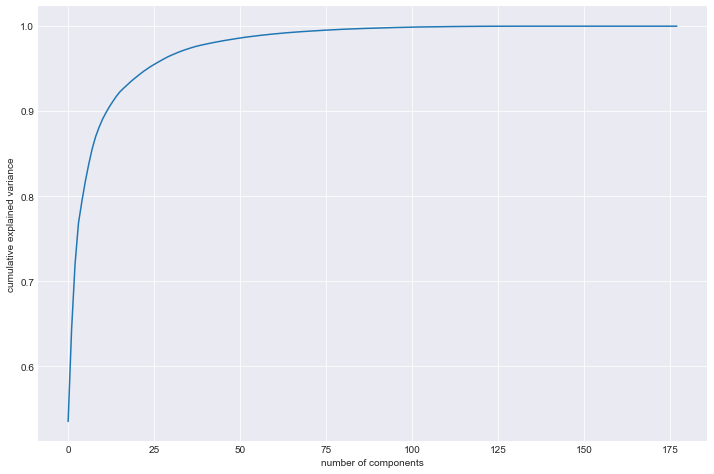

In [94]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

##### **Looks like 35 components are enough to describe 95% of the variance in the dataset**
- We'll choose 35 components for our modeling

In [95]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets

pca_final = IncrementalPCA(n_components=35)

In [96]:
X_train_pca = pca_final.fit_transform(X_train_res)
X_train_pca.shape

(30774, 35)

In [97]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(X_train_pca.transpose())
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.006201618351595638 , min corr:  -0.01768816109239678


In [98]:
#Applying selected components to the test data - 50 components
X_test_pca = pca_final.transform(X_test)
X_test_pca.shape

(8972, 35)

For the prediction of churn customers we will be fitting variety of models and select one which is the best predictor of churn. Models trained are,<br>
    1. Logistic Regression<br>
    2. Decision Tree<br>
    3. Boosting models - XGBoost Classifier<br>

### 1. Logistic Regression 

#### Applying Logistic Regression on our principal components

In [99]:
lr0 = LogisticRegression(class_weight='balanced')

In [100]:
modelfit(lr0, X_train_pca, y_train_res)


Model Report
Accuracy : 0.8335
Recall/Sensitivity : 0.8469
AUC Score (Train): 0.905654
CV Score : Mean - 0.9048313 | Std - 0.006624653 | Min - 0.8915886 | Max - 0.9085144


In [101]:
# predictions on Test data
pred_probs_test = lr0.predict(X_test_pca)
getModelMetrics(y_test,pred_probs_test)

Roc_auc_score : 0.8167899348876513
Sensitivity/Recall : 0.8105849582172702
Specificity: 0.8229949115580325
False Positive Rate: 0.17700508844196752
Positive predictive value: 0.28487518355359764
Negative Predictive value: 0.9803723481021792
sklearn precision score value: 0.28487518355359764


In [102]:
print("Accuracy : {}".format(metrics.accuracy_score(y_test,pred_probs_test)))
print("Recall : {}".format(metrics.recall_score(y_test,pred_probs_test)))
print("Precision : {}".format(metrics.precision_score(y_test,pred_probs_test)))

Accuracy : 0.8220017833259028
Recall : 0.8105849582172702
Precision : 0.28487518355359764


In [103]:
#Making prediction on the test data
pred_probs_train = lr0.predict_proba(X_train_pca)[:,1]
print("roc_auc_score(Train) {:2.2}".format(metrics.roc_auc_score(y_train_res, pred_probs_train)))

roc_auc_score(Train) 0.91


In [104]:
cut_off_prob=0.5
y_train_df = predictChurnWithProb(lr0,X_train_pca,y_train_res,cut_off_prob)
y_train_df.head()

Roc_auc_score : 0.8334953187136658
Sensitivity/Recall : 0.8468804159445408
Specificity: 0.8201102214827909
False Positive Rate: 0.1798897785172091
Positive predictive value: 0.7385324567369456
Negative Predictive value: 0.8992645801265606
sklearn precision score value: 0.7385324567369456


,churn,churn_Prob,final_predicted
0,0,0.711068,1
1,0,0.007460,0
2,0,0.102102,0
3,0,0.019422,0
4,0,0.837367,1


**Plotting the ROC Curve :**
An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

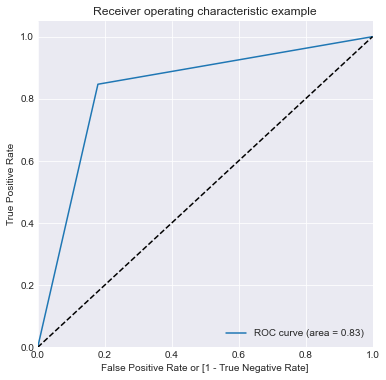

(array([0.        , 0.17988978, 1.        ]),
 array([0.        , 0.84688042, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [105]:
draw_roc(y_train_df.churn, y_train_df.final_predicted)

The roc curve is lying in the top left corner which is a sign of a good fit.

In [106]:
#draw_roc(y_pred_final.Churn, y_pred_final.predicted)
print("roc_auc_score : {:2.2f}".format(metrics.roc_auc_score(y_train_df.churn, y_train_df.final_predicted)))

roc_auc_score : 0.83


**Finding Optimal Cutoff Point**<br>
Since recall or sensitivity is a much more important metrics for churn prediction. A trade off between sensitivity(or recall) and specificity is to be considered in doing so. We will try adjusting the probability threshold which shall lead to higher sensitivity or recall rate.

     prob  accuracy     sensi     speci
0.0   0.0  0.374992  1.000000  0.000000
0.1   0.1  0.604439  0.980503  0.378808
0.2   0.2  0.700006  0.956499  0.546116
0.3   0.3  0.761032  0.926256  0.661901
0.4   0.4  0.802398  0.888562  0.750702
0.5   0.5  0.830149  0.846880  0.820110
0.6   0.6  0.844869  0.788475  0.878704
0.7   0.7  0.845259  0.724610  0.917646
0.8   0.8  0.823520  0.611265  0.950868
0.9   0.9  0.700916  0.227470  0.984975


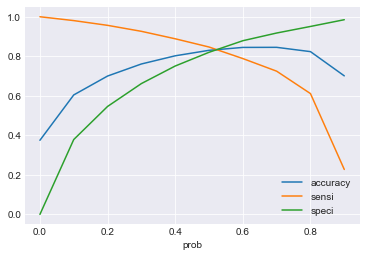

In [107]:
# finding cut-off with the right balance of the metrices
# sensitivity vs specificity trade-off
findOptimalCutoff(y_train_df)

#### **From the curve above, 0.45 is the optimum point .**
Although, other cutoff between 0.4 and 0.6 can also be taken but to keep the test sensitivity/recall significant we choose 0.45. At this point there is a balance of sensitivity, specificity and accuracy.

In [108]:
# predicting with the choosen cut-off on train
cut_off_prob = 0.45
predictChurnWithProb(lr0,X_train_pca,y_train_res,cut_off_prob)

Roc_auc_score : 0.8274473739364991
Sensitivity/Recall : 0.868370883882149
Specificity: 0.7865238639908495
False Positive Rate: 0.21347613600915047
Positive predictive value: 0.7093508883697883
Negative Predictive value: 0.9087523277467412
sklearn precision score value: 0.7093508883697883


,churn,churn_Prob,final_predicted
0,0,0.711068,1
1,0,0.007460,0
2,0,0.102102,0
3,0,0.019422,0
4,0,0.837367,1
...,...,...,...
30769,1,0.811415,1
30770,1,0.929254,1
30771,1,0.659089,1
30772,1,0.627844,1


**Making prediction on test**

In [109]:
# predicting with the choosen cut-off on test
predictChurnWithProb(lr0,X_test_pca,y_test,cut_off_prob)

Roc_auc_score : 0.8134531548137713
Sensitivity/Recall : 0.8384401114206128
Specificity: 0.78846619820693
False Positive Rate: 0.21153380179307002
Positive predictive value: 0.2563884156729131
Negative Predictive value: 0.982487922705314
sklearn precision score value: 0.2563884156729131


,churn,churn_Prob,final_predicted
4265,0,0.422425,0
29221,0,0.560329,1
974,0,0.374224,0
1602,0,0.283781,0
10225,0,0.148083,0
...,...,...,...
6262,0,0.182158,0
1424,0,0.046592,0
18308,0,0.260184,0
22978,0,0.100705,0


The resulting model, after PCA and logistic regression (with optimal cutoff setting) has a right balance of different metrics score for sensitivity, specificity and Roc Accuracy on the train and test set.
- **train sensitivity  :** 86.83%, **train roc auc score  :** 82.74%
- **test sensitivity   :** 83.84%, **test roc auc score  :** 81.34%

### 2. Decision Tree

#### Applying Decision Tree Classifier on our principal components with Hyperparameter tuning

In [110]:
dt0 = DecisionTreeClassifier(class_weight='balanced',
                             max_features='auto',
                             min_samples_split=100,
                             min_samples_leaf=100,
                             max_depth=6,
                             random_state=10)
modelfit(dt0, X_train_pca, y_train_res)


Model Report
Accuracy : 0.773
Recall/Sensitivity : 0.7675
AUC Score (Train): 0.847838
CV Score : Mean - 0.8422527 | Std - 0.01155923 | Min - 0.8204876 | Max - 0.8547357


In [111]:
# make predictions
pred_probs_test = dt0.predict(X_test_pca)
#Let's check the model metrices.
getModelMetrics(actual_churn=y_test,pred_churn=pred_probs_test)

Roc_auc_score : 0.7339733314074783
Sensitivity/Recall : 0.6894150417827298
Specificity: 0.7785316210322268
False Positive Rate: 0.2214683789677732
Positive predictive value: 0.21308652604390874
Negative Predictive value: 0.9664611219732291
sklearn precision score value: 0.21308652604390874


In [112]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': range(5,15,3),
    'min_samples_leaf': range(100, 400, 50),
    'min_samples_split': range(100, 400, 100),
    'max_features': [8,10,15]
}
# Create a based model
dt = DecisionTreeClassifier(class_weight='balanced',random_state=10)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = dt, param_grid = param_grid, 
                          cv = 3, n_jobs = 4,verbose = 1,scoring="f1_weighted")

In [113]:
# Fit the grid search to the data
grid_search.fit(X_train_pca, y_train_res)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   57.2s
[Parallel(n_jobs=4)]: Done 648 out of 648 | elapsed:  1.5min finished


GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=10),
             n_jobs=4,
             param_grid={'max_depth': range(5, 15, 3),
                         'max_features': [8, 10, 15],
                         'min_samples_leaf': range(100, 400, 50),
                         'min_samples_split': range(100, 400, 100)},
             scoring='f1_weighted', verbose=1)

In [114]:
# printing the optimal accuracy score and hyperparameters
print('We can get recall of',grid_search.best_score_,'using',grid_search.best_params_)

We can get recall of 0.8048269838949005 using {'max_depth': 11, 'max_features': 15, 'min_samples_leaf': 100, 'min_samples_split': 100}


In [115]:
# model with the best hyperparameters
dt_final = DecisionTreeClassifier(class_weight='balanced',
                             max_depth=14,
                             min_samples_leaf=100, 
                             min_samples_split=100,
                             max_features=15,
                             random_state=10)

In [116]:
modelfit(dt_final,X_train_pca,y_train_res)


Model Report
Accuracy : 0.8275
Recall/Sensitivity : 0.8324
AUC Score (Train): 0.910881
CV Score : Mean - 0.8847231 | Std - 0.007900156 | Min - 0.8700165 | Max - 0.8907941


In [117]:
# make predictions
pred_probs_test = dt_final.predict(X_test_pca)
#Let's check the model metrices.
getModelMetrics(actual_churn=y_test,pred_churn=pred_probs_test)

Roc_auc_score : 0.7487550562131436
Sensitivity/Recall : 0.6838440111420613
Specificity: 0.8136661012842258
False Positive Rate: 0.18633389871577416
Positive predictive value: 0.24199112863479547
Negative Predictive value: 0.9673051994814922
sklearn precision score value: 0.24199112863479547


In [118]:
# classification report
print(classification_report(y_test,pred_probs_test))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      8254
           1       0.24      0.68      0.36       718

    accuracy                           0.80      8972
   macro avg       0.60      0.75      0.62      8972
weighted avg       0.91      0.80      0.84      8972



Even after hyperparameter tuning for the Decision Tree. The recall rate is 68.38% which is not very significant to predict the churn.

Let's see if we can achive a better Recall rate by deciding an optimal cut-off for the model to predict churn.

In [119]:
# predicting churn with default cut-off 0.5
cut_off_prob = 0.5
y_train_df = predictChurnWithProb(dt_final,X_train_pca,y_train_res,cut_off_prob)
y_train_df.head()

Roc_auc_score : 0.827507407178471
Sensitivity/Recall : 0.8324090121317158
Specificity: 0.8226058022252262
False Positive Rate: 0.17739419777477383
Positive predictive value: 0.7379013673375326
Negative Predictive value: 0.8910790718630323
sklearn precision score value: 0.7379013673375326


,churn,churn_Prob,final_predicted
0,0,0.751696,1
1,0,0.025001,0
2,0,0.000000,0
3,0,0.408020,0
4,0,0.392413,0


     prob  accuracy     sensi     speci
0.0   0.0  0.531423  1.000000  0.250286
0.1   0.1  0.642945  0.991941  0.433555
0.2   0.2  0.720381  0.971317  0.569824
0.3   0.3  0.759180  0.943068  0.648851
0.4   0.4  0.804673  0.886222  0.755745
0.5   0.5  0.826282  0.832409  0.822606
0.6   0.6  0.831969  0.785182  0.860040
0.7   0.7  0.829759  0.701473  0.906728
0.8   0.8  0.808800  0.576603  0.948113
0.9   0.9  0.754176  0.375043  0.981647


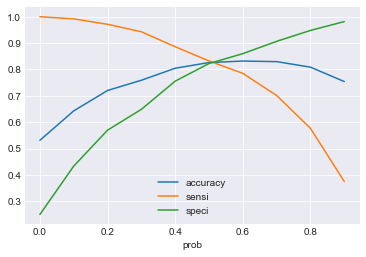

In [120]:
# finding cut-off with the right balance of the metrices
findOptimalCutoff(y_train_df)

**From the curve above, let'choose 0.4 as the optimum point to make a high enough sensitivity.**

In [121]:
# predicting churn with cut-off 0.4
cut_off_prob=0.4
y_train_df = predictChurnWithProb(dt_final,X_train_pca,y_train_res,cut_off_prob)
y_train_df.head()

Roc_auc_score : 0.8209834359612681
Sensitivity/Recall : 0.8862218370883882
Specificity: 0.7557450348341479
False Positive Rate: 0.24425496516585213
Positive predictive value: 0.6852261306532663
Negative Predictive value: 0.917155656508297
sklearn precision score value: 0.6852261306532663


,churn,churn_Prob,final_predicted
0,0,0.751696,1
1,0,0.025001,0
2,0,0.000000,0
3,0,0.408020,1
4,0,0.392413,0


In [122]:
#Lets see how it performs on test data.
y_test_df= predictChurnWithProb(dt_final,X_test_pca,y_test,cut_off_prob)
y_test_df.head()

Roc_auc_score : 0.7495304040988314
Sensitivity/Recall : 0.7506963788300836
Specificity: 0.7483644293675794
False Positive Rate: 0.25163557063242065
Positive predictive value: 0.20603975535168195
Negative Predictive value: 0.9718376337319069
sklearn precision score value: 0.20603975535168195


,churn,churn_Prob,final_predicted
4265,0,0.359351,0
29221,0,0.111468,0
974,0,0.464776,1
1602,0,0.372679,0
10225,0,0.588951,1


- Decision tree after selecting optimal cut-off also is resulting in a model with
<br>**Train Recall : 88.62%**  and  **Train Roc_auc_score : 82.09**
<br>**Test Recall : 75.06%**  and  **Test Roc_auc_score : 74.95**


### 3. XGBoost Classifier

#### Applying XGBoost Classifier on our principal components with Hyperparameter tuning


In [123]:
# Fitting the XGBClassifier
xgb1 = XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)

In [124]:
# Model fit and performance on Train data
modelfit(xgb1, X_train_pca, y_train_res)


Model Report
Accuracy : 0.9996
Recall/Sensitivity : 0.9997
AUC Score (Train): 0.999999
CV Score : Mean - 0.9825866 | Std - 0.001988733 | Min - 0.9789102 | Max - 0.9844574


In [125]:
# Hyperparameter tunning for the XGBClassifer
param_test1 = {'max_depth':range(3,10,2),'min_child_weight':range(1,6,2)}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=3)
gsearch1.fit(X_train_pca, y_train_res)

GridSearchCV(cv=3,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=5,
                                     n_estimators=140, nthread=4, seed=27,
                                     subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='f1')

In [126]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.9123677003149663)

In [127]:
# Some more hyperparameter tunning for the XGBClassifer
param_test2 = param_test3 = {'gamma':[i/10.0 for i in range(0,5)]}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='f1',n_jobs=4,iid=False, cv=3)
gsearch2.fit(X_train_pca, y_train_res)

GridSearchCV(cv=3,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=9,
                                     n_estimators=140, nthread=4, seed=27,
                                     subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}, scoring='f1')

In [128]:
gsearch2.best_params_, gsearch2.best_score_

({'gamma': 0.2}, 0.9132403362245795)

In [129]:
# Final XGBClassifier
xgb2 = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)

In [130]:
# Fit Train data
modelfit(xgb2, X_train_pca, y_train_res)


Model Report
Accuracy : 0.9972
Recall/Sensitivity : 0.998
AUC Score (Train): 0.999965
CV Score : Mean - 0.9824632 | Std - 0.002207501 | Min - 0.9780925 | Max - 0.9839672


In [131]:
# Prediction on Test data
dtest_predictions = xgb2.predict(X_test_pca)

In [132]:
# Model evaluation on Test data
getModelMetrics(y_test,dtest_predictions)

Roc_auc_score : 0.7351546612328758
Sensitivity/Recall : 0.5222841225626741
Specificity: 0.9480251999030773
False Positive Rate: 0.05197480009692271
Positive predictive value: 0.4664179104477612
Negative Predictive value: 0.9580068560235063
sklearn precision score value: 0.4664179104477612


Let's see if we can achive a better Recall rate by deciding an optimal cut-off for the model to predict churn.

In [133]:
# predicting churn with default cut-off 0.5
cut_off_prob=0.5
y_train_df = predictChurnWithProb(xgb2,X_train_pca,y_train_res,cut_off_prob)
y_train_df.head()

Roc_auc_score : 0.9972357631786145
Sensitivity/Recall : 0.9980069324090122
Specificity: 0.9964645939482167
False Positive Rate: 0.0035354060517833004
Positive predictive value: 0.9941303409581356
Negative Predictive value: 0.9988013966334879
sklearn precision score value: 0.9941303409581356


,churn,churn_Prob,final_predicted
0,0,0.086740,0
1,0,0.002138,0
2,0,0.030732,0
3,0,0.027217,0
4,0,0.416803,0


     prob  accuracy     sensi     speci
0.0   0.0  0.374992  1.000000  0.000000
0.1   0.1  0.940112  1.000000  0.904180
0.2   0.2  0.977026  1.000000  0.963242
0.3   0.3  0.989537  0.999827  0.983363
0.4   0.4  0.994866  0.999480  0.992097
0.5   0.5  0.997043  0.998007  0.996465
0.6   0.6  0.997173  0.994887  0.998544
0.7   0.7  0.994671  0.986568  0.999532
0.8   0.8  0.984857  0.959792  0.999896
0.9   0.9  0.945506  0.854679  1.000000


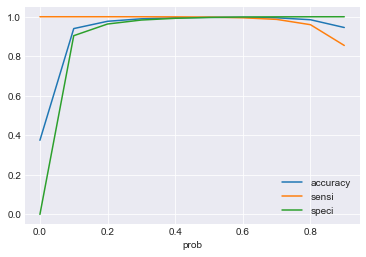

In [134]:
# Finding optimal cut-off probability
findOptimalCutoff(y_train_df)

In [135]:
# Selecting 0.2 as cut-off in an attempt to improve recall rate
cut_off_prob=0.2
predictChurnWithProb(xgb2,X_train_pca,y_train_res,cut_off_prob)

Roc_auc_score : 0.9816210876572735
Sensitivity/Recall : 1.0
Specificity: 0.9632421753145471
False Positive Rate: 0.03675782468545284
Positive predictive value: 0.9422715767126644
Negative Predictive value: 1.0
sklearn precision score value: 0.9422715767126644


,churn,churn_Prob,final_predicted
0,0,0.086740,0
1,0,0.002138,0
2,0,0.030732,0
3,0,0.027217,0
4,0,0.416803,1
...,...,...,...
30769,1,0.941922,1
30770,1,0.961354,1
30771,1,0.962485,1
30772,1,0.986953,1


**Making prediction on test**

In [136]:
y_test_df= predictChurnWithProb(xgb2,X_test_pca,y_test,cut_off_prob)
y_test_df.head()

Roc_auc_score : 0.7942140655362168
Sensitivity/Recall : 0.7047353760445683
Specificity: 0.8836927550278653
False Positive Rate: 0.11630724497213472
Positive predictive value: 0.3451568894952251
Negative Predictive value: 0.971755928590461
sklearn precision score value: 0.3451568894952251


,churn,churn_Prob,final_predicted
4265,0,0.312104,1
29221,0,0.093839,0
974,0,0.139564,0
1602,0,0.054285,0
10225,0,0.033379,0


## Final Choice of Model

Recall is the most important business metric for the telecom churn problem. The company would like to identify most customers at risk of churning, even if there are many customers that are misclassified as churn. The cost to the company of churning is much higher than having a few false positives.

Overall, the **Logistic Regression** model with probability cut-off = 0.45, performs best. It achieved the **best recall accuracy of 83.84%** for test data. Also the overall accuracy and specificity is consistent for Test and train data, thus avoiding overfitting. The precision is compromised in this effort but the business objective to predict Churn customers is most accuratety captured by it.

Decision Tree and XGBoost Classifier, both seems to overfit the data.

### Identifying important features

Test_train Splitting the 'hv_users' data frame for interpretable models using the same randomized state

In [137]:
#putting features variables in X
X = hv_users_PCA.drop(['churn'], axis=1)

#putting response variables in Y
y = hv_users_PCA['churn']    

# Splitting the data into train and test
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [138]:
# run a random forest model on train data
max_features = int(round(np.sqrt(X_train_new.shape[1])))    # number of variables to consider to split each node
print(max_features)

rf_model = RandomForestClassifier(n_estimators=100, max_features=max_features, class_weight={0:0.1, 1: 0.9}, oob_score=True, random_state=4, verbose=1)

13


In [139]:
# fit model
rf_model.fit(X_train_new, y_train_new)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   27.4s finished


RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, max_features=13,
                       oob_score=True, random_state=4, verbose=1)

In [140]:
# OOB score
rf_model.oob_score_

0.9430113690646794

In [141]:
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import roc_auc_score

In [142]:
# predict churn on test data
y_pred = rf_model.predict(X_test_new)

# create onfusion matrix
cm = confusion_matrix(y_test_new, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test_new, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[8161   93]
 [ 413  305]]
Sensitivity: 	0.42
Specificity: 	0.99
ROC:    	 0.86


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [143]:
hv_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29906 entries, 0 to 29905
Columns: 187 entries, mobile_number to Total_roam_mou_8
dtypes: category(1), datetime64[ns](6), float64(147), int32(6), int64(27)
memory usage: 41.8 MB


In [144]:
# Removing date and category type column with mobile number as well
hv_users_num = hv_users.select_dtypes(exclude=['category','datetime64']).drop('mobile_number',axis=1)

In [145]:
# predictors
features = hv_users_num.drop('churn', axis=1).columns

# feature_importance
importance = rf_model.feature_importances_

# create dataframe
feature_importance = pd.DataFrame({'variables': features, 'importance_percentage': importance*100})
feature_importance = feature_importance[['variables', 'importance_percentage']]

# sort features
feature_importance = feature_importance.sort_values('importance_percentage', ascending=False).reset_index(drop=True)
print("Sum of importance=", feature_importance.importance_percentage.sum())
feature_importance

Sum of importance= 99.99999999999999


,variables,importance_percentage
0,Total_loc_mou_8,5.039754
1,total_ic_mou_8,4.604251
2,loc_ic_t2t_mou_8,4.484928
3,loc_ic_mou_8,4.133196
4,total_month_rech_8,3.424155
5,loc_ic_t2m_mou_8,3.138400
6,og_to_ic_mou_8,2.555722
7,loc_og_t2m_mou_8,2.483180
8,Total_roam_mou_8,2.178547
9,last_day_rch_amt_8,2.132216


In [146]:
# extract top 'n' features
top_n = 30
top_features = feature_importance.variables[0:top_n]

<AxesSubplot:>

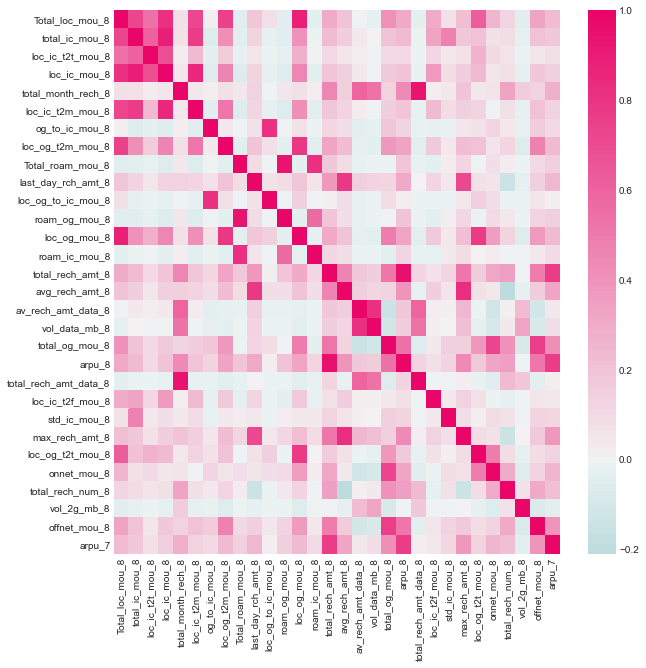

In [147]:
# plot feature correlation
plt.rcParams["figure.figsize"] =(10,10)
mycmap = sns.diverging_palette(199, 359, s=99, center="light", as_cmap=True)
sns.heatmap(data=X_train_new[top_features].corr(), center=0.0, cmap=mycmap)

### From these 30 features we will select the top 10 features to see how how they are correlated with churn activity using the logistc regression again

In [148]:
top_10 = feature_importance.variables.values.tolist()[0:10]
top_10

['Total_loc_mou_8',
 'total_ic_mou_8',
 'loc_ic_t2t_mou_8',
 'loc_ic_mou_8',
 'total_month_rech_8',
 'loc_ic_t2m_mou_8',
 'og_to_ic_mou_8',
 'loc_og_t2m_mou_8',
 'Total_roam_mou_8',
 'last_day_rch_amt_8']

In [149]:
X_train_top_10 = X_train_new[top_10]
X_test_top_10 = X_test_new[top_10]

In [150]:
lr0_top_10 = LogisticRegression(class_weight='balanced')

In [151]:
modelfit(lr0_top_10, X_train_top_10, y_train_new)


Model Report
Accuracy : 0.7803
Recall/Sensitivity : 0.8347
AUC Score (Train): 0.867466
CV Score : Mean - 0.866516 | Std - 0.01349444 | Min - 0.8462209 | Max - 0.8863931


In [152]:
# predictions on Test data
pred_probs_test = lr0_top_10.predict(X_test_top_10)
getModelMetrics(y_test_new,pred_probs_test)

Roc_auc_score : 0.7862832437788246
Sensitivity/Recall : 0.8454038997214485
Specificity: 0.7271625878362006
False Positive Rate: 0.27283741216379936
Positive predictive value: 0.21231199720181881
Negative Predictive value: 0.9818419761164731
sklearn precision score value: 0.21231199720181881


In [153]:
print("Accuracy : {}".format(metrics.accuracy_score(y_test_new,pred_probs_test)))
print("Recall : {}".format(metrics.recall_score(y_test_new,pred_probs_test)))
print("Precision : {}".format(metrics.precision_score(y_test_new,pred_probs_test)))

Accuracy : 0.7366250557289344
Recall : 0.8454038997214485
Precision : 0.21231199720181881


In [154]:
#Making prediction on the test data
pred_probs_train = lr0_top_10.predict_proba(X_train_top_10)[:,1]
print("roc_auc_score(Train) {:2.2}".format(metrics.roc_auc_score(y_train_new, pred_probs_train)))

roc_auc_score(Train) 0.87


In [155]:
cut_off_prob=0.5
y_train_df = predictChurnWithProb(lr0_top_10,X_train_top_10,y_train_new,cut_off_prob)
y_train_df.head()

Roc_auc_score : 0.7802779697716666
Sensitivity/Recall : 0.8347058823529412
Specificity: 0.725850057190392
False Positive Rate: 0.27414994280960797
Positive predictive value: 0.21204423191870891
Negative Predictive value: 0.9802696250526611
sklearn precision score value: 0.21204423191870891


,churn,churn_Prob,final_predicted
21854,0,0.746430,1
9520,0,0.024641,0
21601,0,0.084451,0
28165,0,0.092021,0
10243,0,0.647090,1


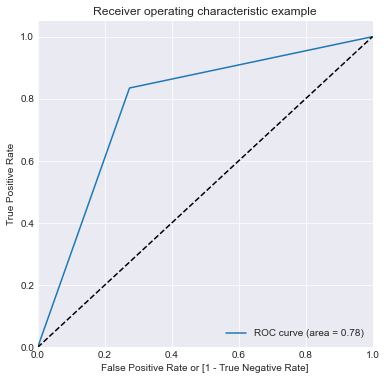

(array([0.        , 0.27414994, 1.        ]),
 array([0.        , 0.83470588, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [156]:
draw_roc(y_train_df.churn, y_train_df.final_predicted)

In [157]:
#draw_roc(y_pred_final.Churn, y_pred_final.predicted)
print("roc_auc_score : {:2.2f}".format(metrics.roc_auc_score(y_train_df.churn, y_train_df.final_predicted)))

roc_auc_score : 0.78


     prob  accuracy     sensi     speci
0.0   0.0  0.081208  1.000000  0.000000
0.1   0.1  0.319910  0.968235  0.262608
0.2   0.2  0.431547  0.945882  0.386087
0.3   0.3  0.532722  0.920000  0.498492
0.4   0.4  0.633133  0.877647  0.611521
0.5   0.5  0.734690  0.834706  0.725850
0.6   0.6  0.828747  0.764118  0.834460
0.7   0.7  0.899016  0.667059  0.919518
0.8   0.8  0.917741  0.134706  0.986950
0.9   0.9  0.917407  0.014706  0.997192


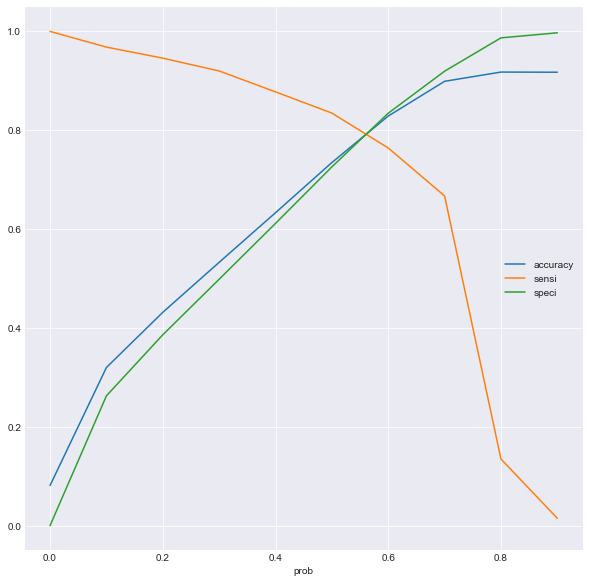

In [158]:
# finding cut-off with the right balance of the metrices
# sensitivity vs specificity trade-off
findOptimalCutoff(y_train_df)

The optimal cutoff point seems to be around 0.55

In [159]:
# predicting with the choosen cut-off on train
cut_off_prob = 0.55
predictChurnWithProb(lr0_top_10,X_train_top_10,y_train_new,cut_off_prob)

Roc_auc_score : 0.7910946302197701
Sensitivity/Recall : 0.8011764705882353
Specificity: 0.781012789851305
False Positive Rate: 0.21898721014869502
Positive predictive value: 0.24434876210979548
Negative Predictive value: 0.9779947916666667
sklearn precision score value: 0.24434876210979548


,churn,churn_Prob,final_predicted
21854,0,0.746430,1
9520,0,0.024641,0
21601,0,0.084451,0
28165,0,0.092021,0
10243,0,0.647090,1
...,...,...,...
12119,0,0.149167,0
24423,0,0.806175,1
14147,0,0.001472,0
23320,0,0.488940,0


In [160]:
# predicting with the choosen cut-off on test
predictChurnWithProb(lr0_top_10,X_test_top_10,y_test_new,cut_off_prob)

Roc_auc_score : 0.7969508157773424
Sensitivity/Recall : 0.8119777158774373
Specificity: 0.7819239156772474
False Positive Rate: 0.2180760843227526
Positive predictive value: 0.24464960134284516
Negative Predictive value: 0.9795113067233268
sklearn precision score value: 0.24464960134284516


,churn,churn_Prob,final_predicted
4265,0,0.715792,1
29221,0,0.486796,0
974,0,0.585592,1
1602,0,0.469011,0
10225,0,0.226444,0
...,...,...,...
6262,0,0.538287,0
1424,0,0.267542,0
18308,0,0.192132,0
22978,0,0.177176,0


In [161]:
logistic_features = list(X_train_top_10.columns)
coefficients_df = pd.DataFrame(lr0_top_10.coef_, columns=logistic_features)
# intercept
intercept_df = pd.DataFrame(lr0_top_10.intercept_.reshape((1,1)), columns = ['intercept'])

In [162]:
# concatenate dataframes
coefficients = pd.concat([intercept_df, coefficients_df], axis=1)
coefficients

,intercept,Total_loc_mou_8,total_ic_mou_8,loc_ic_t2t_mou_8,loc_ic_mou_8,total_month_rech_8,loc_ic_t2m_mou_8,og_to_ic_mou_8,loc_og_t2m_mou_8,Total_roam_mou_8,last_day_rch_amt_8
0,1.37343,-0.000561,-0.001573,0.002556,-0.004578,-0.000999,0.001319,-0.007671,-0.000614,0.002049,-0.002112


## Business Insights

* Telecom company needs to pay attention to the roaming rates. They need to provide good offers to the customers who are using services from a roaming zone.
* The company needs to focus on the STD and ISD rates. Perhaps, the rates are too high. Provide them with some kind of STD and ISD packages.
* To look into both of the issues stated above, it is desired that the telecom company collects customer query and complaint data and work on their services according to the needs of customers. 